# NYC Property Sales Analysis
This notebook analyzes NYC Property Sales data. It includes data cleaning, visualization, and exploration of the relationships between `SALE PRICE` and other features.

In [4]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

## Load and Clean Data

In [15]:
# Define correct column names
column_names = [
    "BOROUGH", "NEIGHBORHOOD", "BUILDING CLASS CATEGORY", 
    "TAX CLASS AT PRESENT", "BLOCK", "LOT", "EASE-MENT", 
    "BUILDING CLASS AT PRESENT", "ADDRESS", "APARTMENT NUMBER", 
    "ZIP CODE", "RESIDENTIAL UNITS", "COMMERCIAL UNITS", 
    "TOTAL UNITS", "LAND SQUARE FEET", "GROSS SQUARE FEET", 
    "YEAR BUILT", "TAX CLASS AT TIME OF SALE", 
    "BUILDING CLASS AT TIME OF SALE", "SALE PRICE", "SALE DATE"
]

# Load the dataset

# Build the relative path to the CSV file
workspace_folder = os.getcwd()  # Or replace with the absolute path if needed

# Construct the path to the CSV file
file_path = os.path.join(workspace_folder, "data", "nyc-rolling-sales.csv")
data = pd.read_csv(
    file_path,
    sep=",",
    quotechar='"',
    names=column_names,
    skiprows=1,
    na_values=[" - "],
    on_bad_lines="skip",
    encoding="utf-8"
)

# Convert numeric columns
numeric_columns = [
    "SALE PRICE", "LAND SQUARE FEET", "GROSS SQUARE FEET", "RESIDENTIAL UNITS", 
    "COMMERCIAL UNITS", "TOTAL UNITS"
]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors="coerce")

# Drop rows with NaN in critical columns
data = data.dropna(subset=["SALE PRICE", "GROSS SQUARE FEET"])

# Reset index
data = data.reset_index(drop=True)

# Convert SALE DATE to datetime
data["SALE DATE"] = pd.to_datetime(data["SALE DATE"], errors="coerce")
data["YEAR"] = data["SALE DATE"].dt.year

# Display cleaned data

## Visualizations

/tmp/ipykernel_3924/23880887.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SALE PRICE RANGE', data=data, palette='Blues_r')


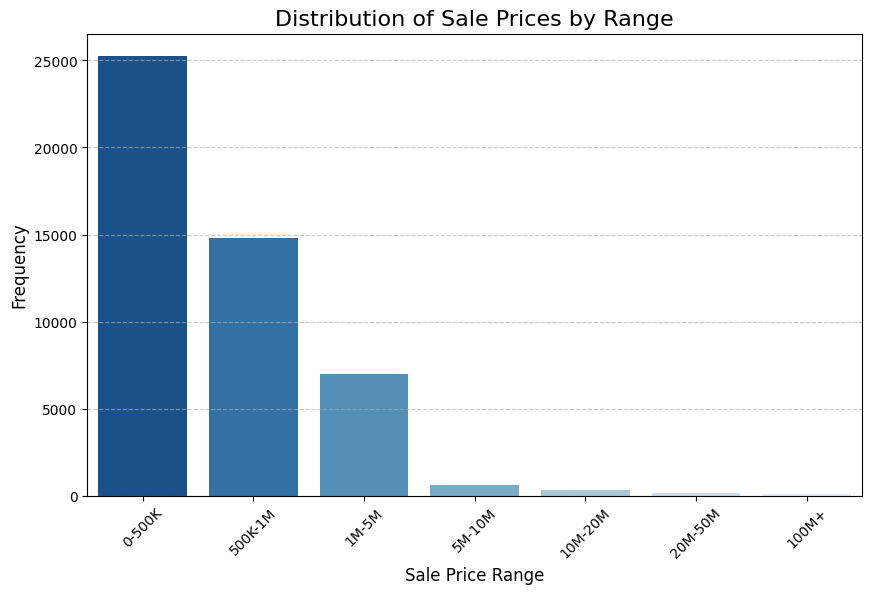

In [ ]:
# 1. Distribution of SALE PRICE


bins = [0, 500000, 1000000, 5000000, 10000000, 20000000, 50000000, 1000000000]  # Custom price ranges
labels = ['0-500K', '500K-1M', '1M-5M', '5M-10M', '10M-20M', '20M-50M', '100M+']

# Create a new column for binned sale prices
data['SALE PRICE RANGE'] = pd.cut(data['SALE PRICE'], bins=bins, labels=labels, include_lowest=True)

# Plot the count of properties in each range
plt.figure(figsize=(10, 6))
sns.countplot(x='SALE PRICE RANGE', data=data, palette='Blues_r')
plt.title("Distribution of Sale Prices by Range", fontsize=16)
plt.xlabel("Sale Price Range", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

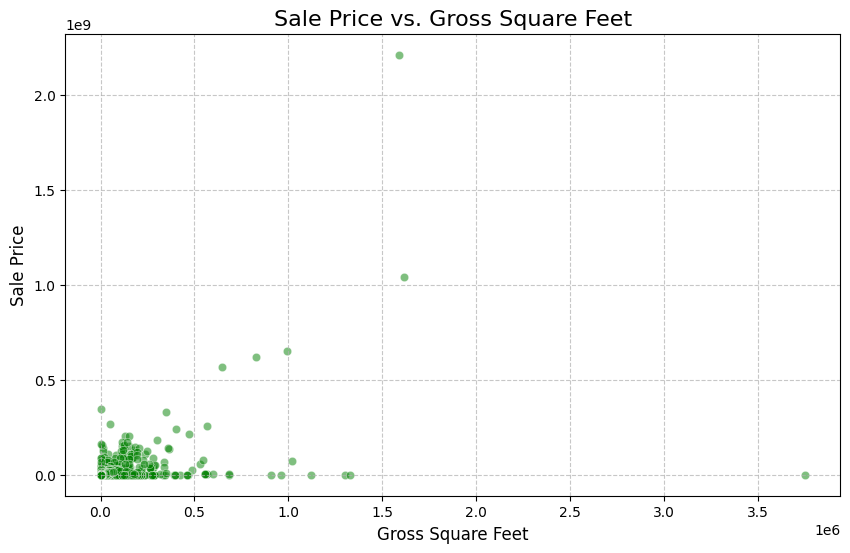

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data["GROSS SQUARE FEET"], y=data["SALE PRICE"], alpha=0.5, color="green")
plt.title("Sale Price vs. Gross Square Feet", fontsize=16)
plt.xlabel("Gross Square Feet", fontsize=12)
plt.ylabel("Sale Price", fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.show()

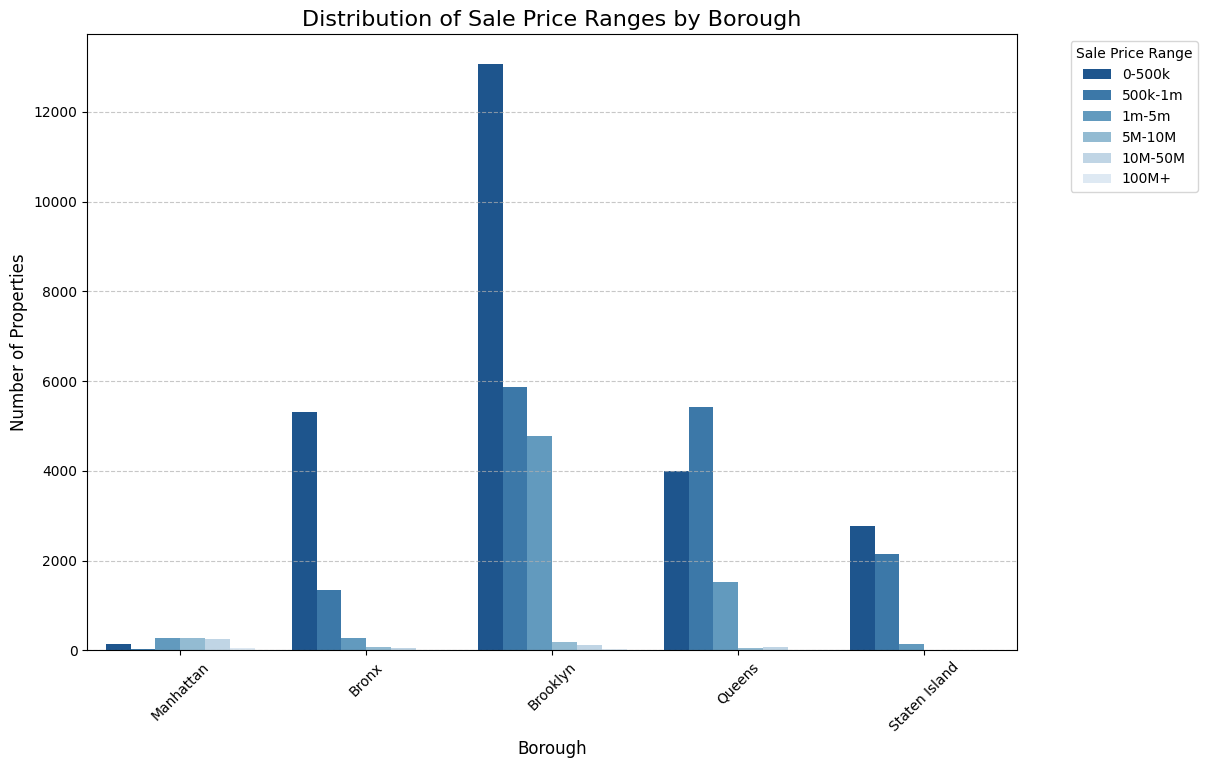

In [ ]:
# Create bins for sale price ranges
bins = [0, 500000, 1000000, 5000000, 10000000, 50000000, float("inf")]
labels = ['0-500k', '500k-1m', '1m-5m', '5M-10M', '10M-50M', '100M+']

# Assign each sale price to a bin
data['SALE PRICE RANGE'] = pd.cut(data['SALE PRICE'], bins=bins, labels=labels, include_lowest=True)

# Replace numbers in the BOROUGH column with borough names
borough_mapping = {
    1: "Manhattan",
    2: "Bronx",
    3: "Brooklyn",
    4: "Queens",
    5: "Staten Island"
}
data["BOROUGH"] = data["BOROUGH"].map(borough_mapping)

# Plot: Count of properties by price range for each borough
plt.figure(figsize=(12, 8))
sns.countplot(x='BOROUGH', hue='SALE PRICE RANGE', data=data, palette='Blues_r')
plt.title("Distribution of Sale Price Ranges by Borough", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Sale Price Range", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


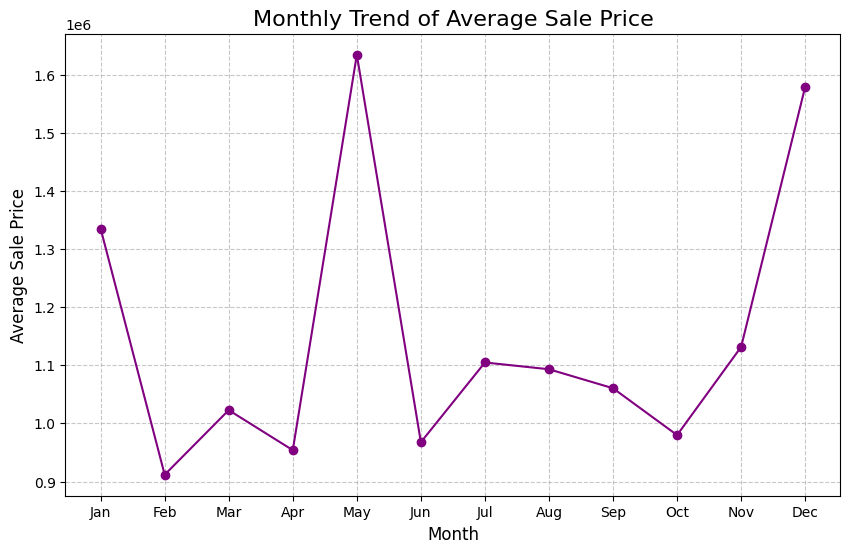

In [24]:
# Ensure SALE DATE is in datetime format
data["SALE DATE"] = pd.to_datetime(data["SALE DATE"], errors="coerce")

# Extract the month from the SALE DATE
data["MONTH"] = data["SALE DATE"].dt.month

# Calculate the average sale price by month
monthly_avg_price = data.groupby("MONTH")["SALE PRICE"].mean()

# Plot the monthly trend
plt.figure(figsize=(10, 6))
plt.plot(
    monthly_avg_price.index, 
    monthly_avg_price.values, 
    marker="o", 
    color="purple"
)
plt.title("Monthly Trend of Average Sale Price", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Sale Price", fontsize=12)
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.show()

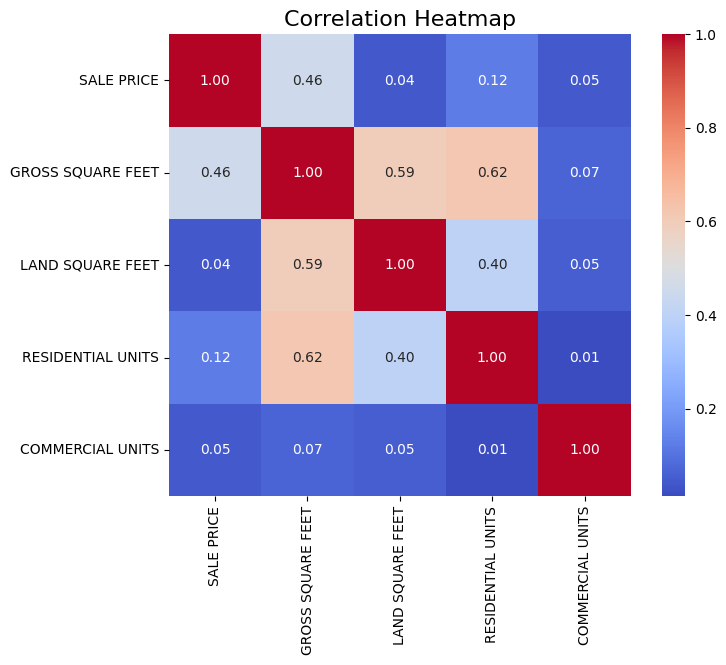

In [ ]:
# 5. Correlation Heatmap
correlation_matrix = data[["SALE PRICE", "GROSS SQUARE FEET", "LAND SQUARE FEET", "RESIDENTIAL UNITS", "COMMERCIAL UNITS"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

## Part3: Basic Pipeline Model

MAE: 947080.99
R²: 0.17


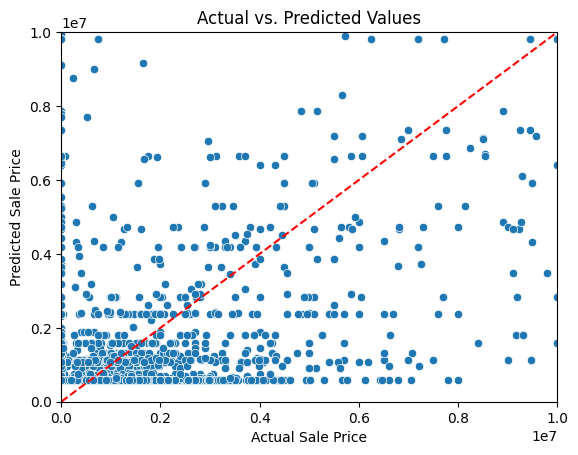

In [25]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# 2. Preprocessing
# Fill missing values
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# 2. Preprocessing
# Fill missing values
numeric_columns = data.select_dtypes(include=["number"]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Define features and target variable
X = data[["GROSS SQUARE FEET", "LAND SQUARE FEET", "RESIDENTIAL UNITS", "COMMERCIAL UNITS"]]
y = data["SALE PRICE"]

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train XGBoost Regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# 5. Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


# Actual vs Predicted
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.xlim(0,10000000)
plt.ylim(0,10000000)
plt.show()

